## 24.5.1 Generating Sequenced Data

In [420]:
import numpy as np
import matplotlib.pyplot as plt

def sum_of_sines(size, d_theta, skip_steps, freqs, amps, phases):
    '''Add together multiple sine waves
    Params
    ------
    size: list of generate data
    d_theta: step in radian between samples
    skip_steps: determines the start of the sequence
    freq, amps and phases shold be all at same lenght
    
    Return
    ------
    numpy array
    '''
    steps = np.array(range(size))
    angles = (d_theta * (steps + skip_steps)).reshape((-1, 1))
    amps, freqs, phases = np.array([amps] * size), np.array([freqs] * size), np.array([phases] * size)
    
    y = amps * np.sin(freqs * (phases + angles))

    return np.sum(y, axis=1)
    

In [421]:
train_seq1 = sum_of_sines(200, .057, 0, [1,2], [1,2], [0,0])
test_seq1 = sum_of_sines(200, .057, 400, [1,2], [1,2], [0,0])

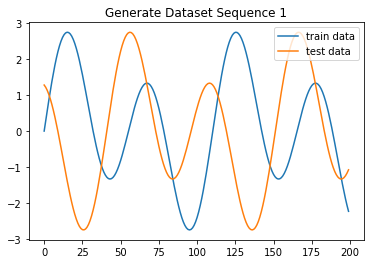

In [422]:
plt.title('Generate Dataset Sequence 1')
plt.plot(train_seq1, label='train data')
plt.plot(test_seq1, label='test data')
plt.legend(loc='upper right')

In [423]:
train_seq2 = sum_of_sines(200, .057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])
test_seq2 = sum_of_sines(200, .057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

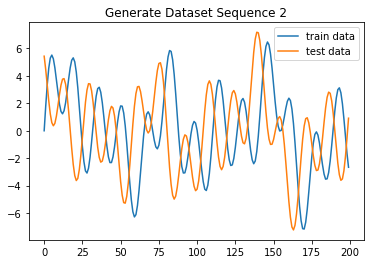

In [424]:
plt.title('Generate Dataset Sequence 2')
plt.plot(train_seq2, label='train data')
plt.plot(test_seq2, label='test data')
plt.legend(loc='upper right')

In [425]:
from sklearn.preprocessing import MinMaxScaler

In [426]:
train_sequence = train_seq1.reshape((-1, 1))
test_sequence = test_seq1.reshape((-1, 1))

scaler = MinMaxScaler()
scaler.fit(train_sequence)
scaled_train_sequence = scaler.transform(train_sequence)
scaled_test_sequence = scaler.transform(test_sequence)

In [427]:
from numpy.lib.stride_tricks import as_strided

def samples_targets(seq, window, step_size):
    """rolling window implementation using stride tricks"""
    row_stride = seq.itemsize * step_size
    col_stride = seq.itemsize
    # leave last item to be a target add +1 to go with the slide window up to end
    num_frames = (len(seq) - window) // step_size
    # output shape
    shape = (num_frames, window, 1)
    # strides: how to move the pointer to next item shape (s, n, m)
    strides = (row_stride, col_stride, col_stride)
    
    samples = as_strided(seq, shape=shape, strides=strides)
    targets = seq[window::step_size]
    
    return samples, targets.flatten()

In [428]:
window_size = 10
step = 1
X_train, y_train = samples_targets(scaled_train_sequence, window_size, step)
X_test, y_test = samples_targets(scaled_test_sequence, window_size, step)

In [429]:
print(X_train.shape, y_train.shape)

(190, 10, 1) (190,)


In [430]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# test if the GPU is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [431]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
190/190 [==============================] - 7s 36ms/step - loss: 0.1846
Epoch 2/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0406
Epoch 3/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0252
Epoch 4/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0180
Epoch 5/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0154
Epoch 6/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0144
Epoch 7/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0132
Epoch 8/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0124
Epoch 9/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0117
Epoch 10/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0108
Epoch 11/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0100
Epoch 12/100
190/190 [==============================] - 4s 23ms/step - loss: 0.0091
E

190/190 [==============================] - 4s 23ms/step - loss: 5.7277e-05
Epoch 96/100
190/190 [==============================] - 4s 23ms/step - loss: 4.4764e-05
Epoch 97/100
190/190 [==============================] - 4s 23ms/step - loss: 4.4548e-05
Epoch 98/100
190/190 [==============================] - 4s 23ms/step - loss: 5.5244e-05
Epoch 99/100
190/190 [==============================] - 4s 22ms/step - loss: 4.6949e-05
Epoch 100/100
190/190 [==============================] - 4s 22ms/step - loss: 5.7200e-05


In [432]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [433]:
# inverse-tranform original targets
inverse_y_train = scaler.inverse_transform(y_train.reshape((-1, 1)))
inverse_y_test = scaler.inverse_transform(y_test.reshape((-1, 1)))

# inverse-transform predictions
inverse_y_train_predict = scaler.inverse_transform(y_train_predict.reshape((-1, 1)))
inverse_y_test_predict = scaler.inverse_transform(y_test_predict.reshape((-1, 1)))

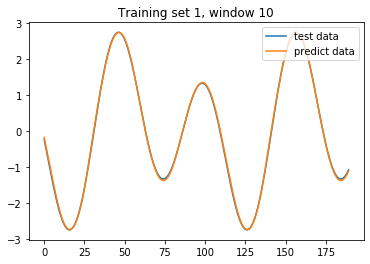

In [434]:
plt.title('Training set 1, window 10')
plt.plot(inverse_y_test, label='test data')
plt.plot(inverse_y_test_predict, label='predict data')
plt.legend(loc='upper right')

Text(0, 0.5, 'loss')

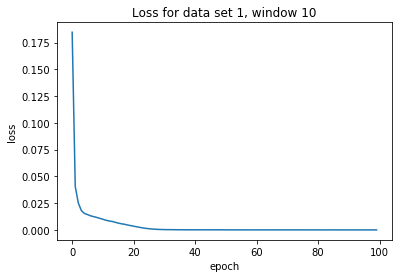

In [435]:
loss = history.history['loss']
epoch = history.epoch
plt.title('Loss for data set 1, window 10')
plt.plot(epoch, loss)
plt.xlabel('epoch')
plt.ylabel('loss')

## Running for data set 2

In [436]:
train_sequence = train_seq2.reshape((-1, 1))
test_sequence = test_seq2.reshape((-1, 1))

scaler = MinMaxScaler()
scaler.fit(train_sequence)
scaled_train_sequence = scaler.transform(train_sequence)
scaled_test_sequence = scaler.transform(test_sequence)

window_size = 5
step = 1
X_train, y_train = samples_targets(scaled_train_sequence, window_size, step)
X_test, y_test = samples_targets(scaled_test_sequence, window_size, step)

In [437]:
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, batch_size=16)

Epoch 1/200
195/195 [==============================] - 3s 15ms/step - loss: 0.2840 - mean_absolute_error: 0.4953
Epoch 2/200
195/195 [==============================] - 0s 1ms/step - loss: 0.2266 - mean_absolute_error: 0.4360
Epoch 3/200
195/195 [==============================] - 0s 1ms/step - loss: 0.1794 - mean_absolute_error: 0.3834
Epoch 4/200
195/195 [==============================] - 0s 988us/step - loss: 0.1420 - mean_absolute_error: 0.3362
Epoch 5/200
195/195 [==============================] - 0s 977us/step - loss: 0.1126 - mean_absolute_error: 0.2936
Epoch 6/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0899 - mean_absolute_error: 0.2571
Epoch 7/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0722 - mean_absolute_error: 0.2252
Epoch 8/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0584 - mean_absolute_error: 0.1992
Epoch 9/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0477 - mean_absolute_e

195/195 [==============================] - 0s 996us/step - loss: 0.0132 - mean_absolute_error: 0.0979
Epoch 74/200
195/195 [==============================] - 0s 997us/step - loss: 0.0130 - mean_absolute_error: 0.0973
Epoch 75/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0971
Epoch 76/200
195/195 [==============================] - 0s 987us/step - loss: 0.0128 - mean_absolute_error: 0.0969
Epoch 77/200
195/195 [==============================] - 0s 997us/step - loss: 0.0127 - mean_absolute_error: 0.0962
Epoch 78/200
195/195 [==============================] - 0s 997us/step - loss: 0.0126 - mean_absolute_error: 0.0959
Epoch 79/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0124 - mean_absolute_error: 0.0955
Epoch 80/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0951
Epoch 81/200
195/195 [==============================] - 0s 985us/step - loss: 0.0122 - mean_absolut

195/195 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0698
Epoch 145/200
195/195 [==============================] - 0s 995us/step - loss: 0.0064 - mean_absolute_error: 0.0694
Epoch 146/200
195/195 [==============================] - 0s 986us/step - loss: 0.0063 - mean_absolute_error: 0.0690
Epoch 147/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0063 - mean_absolute_error: 0.0687
Epoch 148/200
195/195 [==============================] - 0s 977us/step - loss: 0.0062 - mean_absolute_error: 0.0682
Epoch 149/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0678
Epoch 150/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_absolute_error: 0.0674
Epoch 151/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_absolute_error: 0.0670
Epoch 152/200
195/195 [==============================] - 0s 1ms/step - loss: 0.0059 - mean_absol

Text(0, 0.5, 'loss')

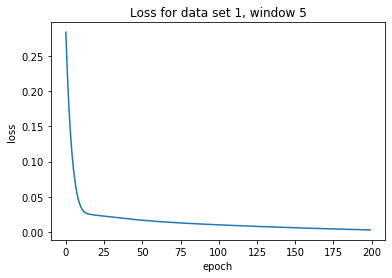

In [438]:
loss = history.history['loss']
epoch = history.epoch
plt.title('Loss for data set 1, window 5')
plt.plot(epoch, loss)
plt.xlabel('epoch')
plt.ylabel('loss')

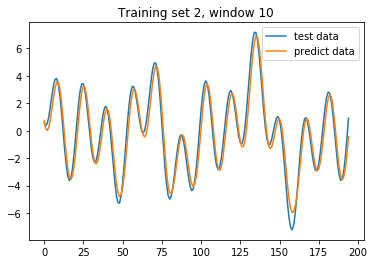

In [439]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# inverse-tranform original targets
inverse_y_train = scaler.inverse_transform(y_train.reshape((-1, 1)))
inverse_y_test = scaler.inverse_transform(y_test.reshape((-1, 1)))

# inverse-transform predictions
inverse_y_train_predict = scaler.inverse_transform(y_train_predict.reshape((-1, 1)))
inverse_y_test_predict = scaler.inverse_transform(y_test_predict.reshape((-1, 1)))

plt.title('Training set 2, window 10')
plt.plot(inverse_y_test, label='test data')
plt.plot(inverse_y_test_predict, label='predict data')
plt.legend(loc='upper right')

## A More Complex Dataset

In [440]:
def sum_of_upsloping_sines(size, d_theta, skip_steps, freqs, amps, phases):
    """Similar to sum_of_sines(), but always sloping upwards
    Params
    ------
    size: list of generate data
    d_theta: step in radian between samples
    skip_steps: determines the start of the sequence
    freq, amps and phases shold be all at same lenght

    Return
    ------
    numpy array
    """
    steps = np.array(range(size))
    angles = (d_theta * (steps + skip_steps)).reshape((-1, 1))
    amps, freqs, phases = np.array([amps] * size), np.array([freqs] * size), np.array([phases] * size)

    y = amps * np.sin(freqs * (phases + angles))
    y = np.sum(y, axis=1)

    changes = y[1:] - y[:-1]

    mask = np.where(changes < 0, 1, -1)

    y[1:] *= mask

    return y

In [441]:
train_seq3 = sum_of_upsloping_sines(200, .057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])
test_seq3 = sum_of_upsloping_sines(200, .057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

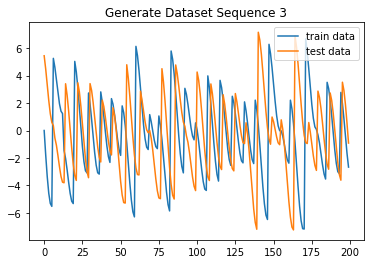

In [442]:
plt.title('Generate Dataset Sequence 3')
plt.plot(train_seq3, label='train data')
plt.plot(test_seq3, label='test data')
plt.legend(loc='upper right')

In [443]:
train_sequence = train_seq3.reshape((-1, 1))
test_sequence = test_seq3.reshape((-1, 1))

scaler = MinMaxScaler()
scaler.fit(train_sequence)
scaled_train_sequence = scaler.transform(train_sequence)
scaled_test_sequence = scaler.transform(test_sequence)

window_size = 3
step = 1
X_train, y_train = samples_targets(scaled_train_sequence, window_size, step)
X_test, y_test = samples_targets(scaled_test_sequence, window_size, step)

In [444]:
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=[window_size, 1]))
model.add(LSTM(6, return_sequences=True))
model.add(LSTM(3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
197/197 [==============================] - 4s 21ms/step - loss: 0.2765 - mean_absolute_error: 0.4795
Epoch 2/300
197/197 [==============================] - 0s 951us/step - loss: 0.2519 - mean_absolute_error: 0.4536
Epoch 3/300
197/197 [==============================] - 0s 968us/step - loss: 0.2277 - mean_absolute_error: 0.4271
Epoch 4/300
197/197 [==============================] - 0s 994us/step - loss: 0.2030 - mean_absolute_error: 0.3989
Epoch 5/300
197/197 [==============================] - 0s 934us/step - loss: 0.1791 - mean_absolute_error: 0.3691
Epoch 6/300
197/197 [==============================] - 0s 983us/step - loss: 0.1545 - mean_absolute_error: 0.3381
Epoch 7/300
197/197 [==============================] - 0s 982us/step - loss: 0.1305 - mean_absolute_error: 0.3061
Epoch 8/300
197/197 [==============================] - 0s 976us/step - loss: 0.1086 - mean_absolute_error: 0.2719
Epoch 9/300
197/197 [==============================] - 0s 990us/step - loss: 0.0879 - mea

197/197 [==============================] - 0s 995us/step - loss: 0.0463 - mean_absolute_error: 0.1735
Epoch 73/300
197/197 [==============================] - 0s 930us/step - loss: 0.0463 - mean_absolute_error: 0.1733
Epoch 74/300
197/197 [==============================] - 0s 954us/step - loss: 0.0461 - mean_absolute_error: 0.1727
Epoch 75/300
197/197 [==============================] - 0s 984us/step - loss: 0.0463 - mean_absolute_error: 0.1726
Epoch 76/300
197/197 [==============================] - 0s 954us/step - loss: 0.0461 - mean_absolute_error: 0.1721
Epoch 77/300
197/197 [==============================] - 0s 966us/step - loss: 0.0460 - mean_absolute_error: 0.1722
Epoch 78/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0460 - mean_absolute_error: 0.1727
Epoch 79/300
197/197 [==============================] - 0s 929us/step - loss: 0.0459 - mean_absolute_error: 0.1726
Epoch 80/300
197/197 [==============================] - 0s 994us/step - loss: 0.0459 - mean_abs

197/197 [==============================] - 0s 995us/step - loss: 0.0350 - mean_absolute_error: 0.1450
Epoch 144/300
197/197 [==============================] - 0s 981us/step - loss: 0.0344 - mean_absolute_error: 0.1434
Epoch 145/300
197/197 [==============================] - 0s 990us/step - loss: 0.0341 - mean_absolute_error: 0.1434
Epoch 146/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0336 - mean_absolute_error: 0.1415
Epoch 147/300
197/197 [==============================] - 0s 999us/step - loss: 0.0328 - mean_absolute_error: 0.1375
Epoch 148/300
197/197 [==============================] - 0s 956us/step - loss: 0.0329 - mean_absolute_error: 0.1363
Epoch 149/300
197/197 [==============================] - 0s 981us/step - loss: 0.0319 - mean_absolute_error: 0.1353
Epoch 150/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_absolute_error: 0.1343
Epoch 151/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0307 - mean

Epoch 214/300
197/197 [==============================] - 0s 995us/step - loss: 0.0266 - mean_absolute_error: 0.1129
Epoch 215/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0261 - mean_absolute_error: 0.1140
Epoch 216/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0262 - mean_absolute_error: 0.1131
Epoch 217/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0.1130
Epoch 218/300
197/197 [==============================] - 0s 981us/step - loss: 0.0260 - mean_absolute_error: 0.1127
Epoch 219/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0260 - mean_absolute_error: 0.1133
Epoch 220/300
197/197 [==============================] - 0s 996us/step - loss: 0.0260 - mean_absolute_error: 0.1126
Epoch 221/300
197/197 [==============================] - 0s 963us/step - loss: 0.0258 - mean_absolute_error: 0.1126
Epoch 222/300
197/197 [==============================] - 0s 982us/step - loss: 0

197/197 [==============================] - 0s 984us/step - loss: 0.0245 - mean_absolute_error: 0.1059
Epoch 285/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0247 - mean_absolute_error: 0.1058
Epoch 286/300
197/197 [==============================] - 0s 978us/step - loss: 0.0248 - mean_absolute_error: 0.1078
Epoch 287/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0245 - mean_absolute_error: 0.1056
Epoch 288/300
197/197 [==============================] - 0s 995us/step - loss: 0.0249 - mean_absolute_error: 0.1065
Epoch 289/300
197/197 [==============================] - 0s 991us/step - loss: 0.0246 - mean_absolute_error: 0.1074
Epoch 290/300
197/197 [==============================] - 0s 972us/step - loss: 0.0248 - mean_absolute_error: 0.1086
Epoch 291/300
197/197 [==============================] - 0s 987us/step - loss: 0.0248 - mean_absolute_error: 0.1059
Epoch 292/300
197/197 [==============================] - 0s 1ms/step - loss: 0.0245 - mean

Text(0, 0.5, 'loss')

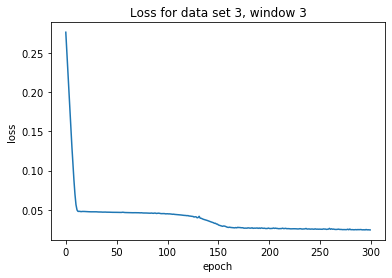

In [448]:
loss = history.history['loss']
epoch = history.epoch
plt.title('Loss for data set 3, window 3')
plt.plot(epoch, loss)
plt.xlabel('epoch')
plt.ylabel('loss')

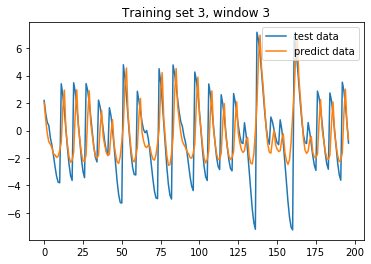

In [449]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# inverse-tranform original targets
inverse_y_train = scaler.inverse_transform(y_train.reshape((-1, 1)))
inverse_y_test = scaler.inverse_transform(y_test.reshape((-1, 1)))

# inverse-transform predictions
inverse_y_train_predict = scaler.inverse_transform(y_train_predict.reshape((-1, 1)))
inverse_y_test_predict = scaler.inverse_transform(y_test_predict.reshape((-1, 1)))

plt.title('Training set 3, window 3')
plt.plot(inverse_y_test, label='test data')
plt.plot(inverse_y_test_predict, label='predict data')
plt.legend(loc='upper right')